## Translation as Language Modeling

Goals:

* Practice getting data into and out of a language model.
    * embeddings (input and output)
    * logits for next words
    * cross-entropy loss
* Explore different methods of *decoding* for sequence generation
* Explain how data flows between the encoder and decoder in a sequence-to-sequence model
* Interpret *attention weights*.

## Setup

Install libraries.

In [66]:
%pip install -q datasets transformers[sentencepiece]

Import PyTorch and the HuggingFace Transformers library.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load a [Marian Machine Translation](https://huggingface.co/transformers/model_doc/marian.html) model.

Specifically, we're using one that was trained on the OPUS corpus (`opus-mt`) to translate text in any romance language (`ROMANCE`) to English (`en`).

In [3]:
from transformers import MarianMTModel, MarianTokenizer
model_name = 'Helsinki-NLP/opus-mt-ROMANCE-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)
print(f"The model has {model.num_parameters():,d} parameters.")

Downloading:   0%|          | 0.00/781k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/761k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

The model has 77,943,296 parameters.


Finally, these wrappers will make the code below easier to understand (you should completely ignore them).

In [4]:
from functools import partial
from transformers.models.marian.modeling_marian import shift_tokens_right
prepend_start_token = partial(
    shift_tokens_right,
    pad_token_id = model.config.pad_token_id, decoder_start_token_id = model.config.decoder_start_token_id)
encoder = model.get_encoder()
decoder = model.get_decoder()
encoder.forward = partial(encoder.forward, output_attentions=True, output_hidden_states=True)
decoder.forward = partial(decoder.forward, output_attentions=True, output_hidden_states=True)


## Warm-up

Let's practice with the tokenizer. This should be mostly review, but we'll do it in the way that the HuggingFace docs do it.

In [5]:
spanish_text = "Yo les doy vida eterna."
spanish_batch = tokenizer(spanish_text, return_tensors='pt', padding=True).to(device)
spanish_batch

{'input_ids': tensor([[ 2554,    29,    73,   131,   860, 21658,     3,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

Since we're only translating one sentence, we can ignore `attention_mask` (which just helps ignore padding tokens) and the extra initial dimension of the `input_ids`.

In [6]:
input_ids = spanish_batch.input_ids
input_ids.shape

torch.Size([1, 8])

In [7]:
tokenizer.convert_ids_to_tokens(input_ids[0])

['▁Yo', '▁les', '▁do', 'y', '▁vida', '▁eterna', '.', '</s>']

Now let's ask the model to generate a translation. Lots of magic happens here; we'll peel back the layers shortly.

In [47]:
translated = model.generate(input_ids = input_ids, num_beams=1, do_sample=False)
translated.shape

torch.Size([1, 8])

Decode the result!

In [48]:
with tokenizer.as_target_tokenizer():
    english_text = tokenizer.decode(translated[0][1:])
english_text

'I give them eternal life.'

In [67]:
#with tokenizer.as_target_tokenizer():
#    english_batch = tokenizer(english_text, return_tensors='pt', padding=True).to(device)
#decoder_input_ids = torch.tensor([model.config.decoder_start_token_id]).unsqueeze(0)
#outputs = model(input_ids=spanish_batch.input_ids, decoder_input_ids=decoder_input_ids)
#outputs.logits.shape

## Predict Next Token

In [65]:
def predict_next_token(source_input_ids, decoded_so_far=[], k=5):
    decoder_input_ids = torch.tensor([model.config.decoder_start_token_id] + decoded_so_far).unsqueeze(0)
    assert input_ids.shape[0] == 1
    with torch.no_grad(): # This tells PyTorch we don't need it to compute gradients for us.
        model_output = model(input_ids = source_input_ids, decoder_input_ids=decoder_input_ids)
    last_token_logits = model_output.logits[0, -1]
    assert len(last_token_logits.shape) == 1
    most_likely_tokens = last_token_logits.topk(k)
    with tokenizer.as_target_tokenizer():
        probs = most_likely_tokens.values.softmax(dim=0)
        return pd.DataFrame({
            'token': [tokenizer.decode(token_id) for token_id in most_likely_tokens.indices],
            'id': most_likely_tokens.indices,
            'probability': probs,
            'logprob': probs.log(),
            'cumulative probability': probs.cumsum(0)
        })


predict_next_token(spanish_batch.input_ids, [20, 685, 224, 16762, 482, 3, 0])

token  id  probability   logprob  cumulative probability
0  </s>   0     0.950323 -0.050953                0.950323
1        39     0.025043 -3.687144                0.975367
2     .   3     0.015829 -4.145927                0.991196
3     -  14     0.006279 -5.070520                0.997475
4     I  20     0.002525 -5.981452                1.000000

## Dig In!

Ok now how did it do that?

You may find it helpful to have the [documentation for the MarianMT model in HuggingFace Transformers](https://huggingface.co/transformers/model_doc/marian.html#transformers.MarianMTModel.forward) open. But you can do all of this without referring to it.

First, let's look at the *loss* that the model gives. We'll compare the correct translation with an incorrect one:

In [11]:
with tokenizer.as_target_tokenizer():
    wrong_target = "I give them eternal death."
    wrong_target_batch = tokenizer(wrong_target, return_tensors='pt', padding=True).to(device)
wrong_target_batch

{'input_ids': tensor([[   20,   685,   224, 16762,  1743,     3,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

Let's **run a forward pass through the full model** (encoder and decoder) with the complete candidate translation. First, the correct translation:

In [12]:
with torch.no_grad():
    model_outputs = model(
        input_ids = spanish_batch.input_ids,
        labels = english_batch.input_ids
    )
model_outputs.loss

tensor(0.2088)

Now (**your turn**) the incorrect translation:

In [13]:
# your code here
with torch.no_grad():
    model_outputs = model(
        input_ids = spanish_batch.input_ids,
        labels = wrong_target_batch.input_ids
    )
model_outputs.loss

tensor(1.3203)

### The guts of the model

I've ripped out all the plumbing code and things you only need in special situations to just show the guts of the model below. **Study this code carefully** with the help of the questions below it. **Add comments** to describe what each line does. Include, where applicable, the *shape* of the tensors involved.

In [14]:
encoder_input_ids = spanish_batch.input_ids
target_ids = english_batch.input_ids
decoder_input_ids = prepend_start_token(target_ids)

with torch.no_grad():
    encoder_outputs = encoder(input_ids = encoder_input_ids)
    # (Aside: an alternative to the above)
    # encoder_input_embeddings = encoder.embed_tokens(encoder_input_ids) * encoder.embed_scale
    # encoder_outputs = encoder(inputs_embeds = encoder_input_embeddings)

    decoder_outputs = decoder(
        input_ids = decoder_input_ids,
        encoder_hidden_states = encoder_outputs.last_hidden_state
    )

    output_embedding = decoder_outputs.last_hidden_state
    token_embeddings = model.lm_head.weight
    logits = output_embedding @ token_embeddings.t()
    logits += model.final_logits_bias

    # ignore the batch dimension.
    logits = logits[0]

nlls_of_correct_tokens = F.cross_entropy(logits, target_ids[0], reduction='none')
nlls_of_correct_tokens.mean()

tensor(0.2088)

**Explain `logits.shape`**.

In [15]:
logits.shape

torch.Size([7, 65001])

*your narrative answer here*


In [16]:
tokenizer.convert_ids_to_tokens(logits.argmax(dim=1))

['▁I', '▁give', '▁them', '▁eternal', '▁life', '.', '</s>']

In [17]:
tokenizer.convert_ids_to_tokens(target_ids[0])

['▁I', '▁give', '▁them', '▁eternal', '▁life', '.', '</s>']

**What tensor contains all of the information from the Spanish sentence that is used to generate the English sentence? Explain each element of the shape of that tensor.**

(The leading "1" is the batch dimension; you can ignore this unless you're translating multiple sentence simultaneously.)

**What is the "shape" of this model?** Specifically:

1. What is the dimensionality of the hidden vectors it uses to represent everything? (How does this relate to the dimensionality of the token embeddings?)
2. How many internal layers does the model have?

In [18]:
encoder_outputs.last_hidden_state.shape

torch.Size([1, 8, 512])

In [19]:
model.config.num_hidden_layers

6

## Visualize attentions

Read these as: the row token looks at the column token.

There are actually 8 attention heads for each of the 6 layers, so to visualize simply, we take the mean over the attention weights (which are all positive).

In [20]:
decoder_outputs.cross_attentions[0].shape

torch.Size([1, 8, 7, 8])

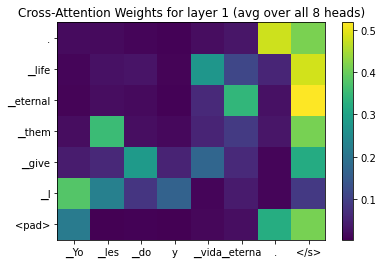

In [21]:
layer = 1
plt.pcolormesh(decoder_outputs.cross_attentions[layer][0].mean(dim=0).cpu().numpy())
plt.title(f"Cross-Attention Weights for layer {layer} (avg over all {model.config.num_attention_heads} heads)")
plt.xticks(torch.arange(8)+.5, tokenizer.convert_ids_to_tokens(encoder_input_ids[0]))
plt.yticks(torch.arange(7)+.5, tokenizer.convert_ids_to_tokens(decoder_input_ids[0]))
plt.colorbar();

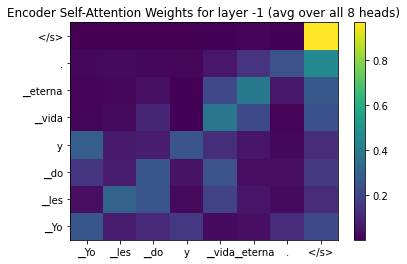

In [22]:
layer = -1
plt.pcolormesh(encoder_outputs.attentions[layer][0].mean(dim=0).cpu().numpy())
plt.title(f"Encoder Self-Attention Weights for layer {layer} (avg over all {model.config.num_attention_heads} heads)")
plt.xticks(torch.arange(8)+.5, tokenizer.convert_ids_to_tokens(encoder_input_ids[0]))
plt.yticks(torch.arange(8)+.5, tokenizer.convert_ids_to_tokens(encoder_input_ids[0]))
plt.colorbar();

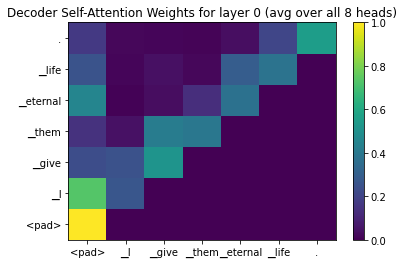

In [23]:
layer = 0
plt.pcolormesh(decoder_outputs.attentions[layer][0].mean(dim=0).cpu().numpy())
plt.title(f"Decoder Self-Attention Weights for layer {layer} (avg over all {model.config.num_attention_heads} heads)")
plt.xticks(torch.arange(7)+.5, tokenizer.convert_ids_to_tokens(decoder_input_ids[0]))
plt.yticks(torch.arange(7)+.5, tokenizer.convert_ids_to_tokens(decoder_input_ids[0]))
plt.colorbar();

## Similarity

Notice that the last step of the model is a dot product with all the token embeddings. Recall that a dot product is a measure of similarity. Let's look at similarity in embedding space.

In [24]:
normalized_token_embeddings = token_embeddings / token_embeddings.norm(p=2, dim=1, keepdim=True)

In [25]:
query_word = "London"
with tokenizer.as_target_tokenizer():
    query_ids = tokenizer.encode(query_word, add_special_tokens=False)
print(query_ids)
query = token_embeddings[query_ids].mean(dim=0)
similarities = query @ normalized_token_embeddings.t()
most_similar_indices = similarities.topk(50).indices
tokenizer.convert_ids_to_tokens(most_similar_indices)

[5226]


['<pad>',
 '▁London',
 '▁Moscow',
 '▁Cambridge',
 '▁Kingston',
 '▁Bremen',
 '▁Windsor',
 '▁Philadelphia',
 '▁Melbourne',
 '▁Baltimore',
 '▁Bristol',
 '▁Cleveland',
 '▁Houston',
 '▁Belfast',
 '▁Denver',
 '▁Baghdad',
 '▁Liverpool',
 '▁Oregon',
 '▁England',
 '▁Edinburgh',
 '▁Tripoli',
 '▁Missouri',
 '▁Flanders',
 '▁Mumbai',
 '▁Churchill',
 '▁Istanbul',
 '▁Bermuda',
 '▁Barcelona',
 '▁Kentucky',
 '▁Detroit',
 '▁Honda',
 '▁Lorraine',
 '▁Tibet',
 '▁Brussels',
 '▁Lusaka',
 '▁Honduran',
 '▁Madison',
 '▁Bordeaux',
 '▁Mormon',
 '▁Maryland',
 '▁Alabama',
 '▁Damascus',
 '▁Tibetan',
 '▁Versailles',
 '▁Iowa',
 '▁Orleans',
 '▁Burgundy',
 '▁Naples',
 '▁Murcia',
 '▁Glasgow']

**Your turn**: now, take query vectors from the `output_embeddings` that were calculated above and find the most similar token embeddings.

Compare the results with the translation output you saw from the model earlier.

In [26]:
# your code here
query = output_embedding[0, 2]
similarities = query @ token_embeddings.t()
most_similar_indices = similarities.topk(50).indices
tokenizer.convert_ids_to_tokens(most_similar_indices)

['▁them',
 '▁you',
 '▁eternal',
 "▁'",
 '▁to',
 '▁everlasting',
 '▁it',
 '▁the',
 "'",
 ',',
 '▁these',
 '▁unto',
 '▁[',
 '▁him',
 '▁forever',
 '▁all',
 '▁that',
 '▁their',
 '▁those',
 '▁up',
 '▁life',
 '▁they',
 '▁for',
 '▁y',
 '▁You',
 '▁ye',
 '▁out',
 '▁Oh',
 '▁I',
 '▁your',
 '▁an',
 '▁people',
 '▁-',
 '▁eternity',
 '▁"',
 '▁(',
 '▁YOU',
 '▁such',
 '▁her',
 '▁birth',
 '▁us',
 '▁perpetual',
 '▁forth',
 '▁of',
 '▁this',
 '▁a',
 '▁lasting',
 '▁Eternal',
 '▁lifelong',
 '▁Him']

## The Logit Lens (optional)

This is an exploration inspired by [this article](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens). Intuition: the Transformer iteratively refines a guess.

In [27]:
# http://stephantul.github.io/python/pytorch/2020/09/18/fast_topk/
def get_ranks(values, indices):
    targets = values[range(len(values)), indices]
    return (values > targets[:, None]).long().sum(dim=1)

In [28]:
ranks = []
print(tokenizer.convert_ids_to_tokens(decoder_input_ids[0]))
for hidden in decoder_outputs.hidden_states[1:]:
    x = model.lm_head(hidden)[0]
    print(tokenizer.convert_ids_to_tokens(x.argmax(dim=1)))
    ranks.append(get_ranks(x, target_ids[0]))
torch.stack(ranks[::-1])


['<pad>', '▁I', '▁give', '▁them', '▁eternal', '▁life', '.']
['▁prevailed', 'oping', '▁give', '▁them', '▁MR', '▁life', 'dog']
['▁foi', 'quarter', '▁give', '▁themselves', '▁Basket', '▁life', 'com']
['▁foi', "'", '▁them', '▁a', 'ly', '▁-', '▁It']
['▁foi', "'", '▁them', '▁all', 'ly', ',', '▁[']
['▁"', "'", '▁them', '▁life', '▁life', ',', '▁[']
['▁I', '▁give', '▁them', '▁eternal', '▁life', ',', '▁-']


tensor([[    0,     0,     0,     0,     0,     3,    10],
        [    4,     1,     0,    17,     0,   131,    48],
        [  123,   197,     0, 15263,     3, 12010,   613],
        [ 1519,  1556,     0, 21065,    60, 22421,  2793],
        [ 9279, 15847,     4, 12473,   109, 21495,  9482],
        [40330,  5603,  6987, 18888, 12455, 26906, 25097]])